# (5) Functional enrichment for KEGG
---
Michaël Pierrelée, Aix Marseille Univ, CNRS, IBDM, UMR7288, FRANCE - michael.pierrelee@univ-amu.fr

*Apache License 2.0*

---

Perform functional enrichment using GSEAPY for KEGG PATHWAY terms and KEGG BRITE objects, a Python implementation of Gene Set Enrichment Analysis (GSEA).

First, the ranked lists were generated for both sub-databases. The means of LFC E and S of genes, with FDR a lower than **1e-4**, related to duplicated KOs, were computed before to sum both LFCs in absolute value

Second, compositions of KEGG terms were retrieved and processed to give 3 gene sets, 1 for PATHWAY and 2 for BRITE. To generate PATHWAY gene sets, we took pathways annotating the KOs in our dataset, except "human diseases", and got from KEGG all KOs assigned to these pathways. All BRITE elements related to gene and protein families, and the KOs assigned to them afterwards, were retrieved. In the BRITE hierarchy, the elements at the 1st position just after the BRITE family gave the 1st gene set, while the elements at the 2nd position gave the 2nd gene set. The latter is thus a more precised subpart of the 1st gene set.

Enrichment was performed by GSEAPY with the following parameters: seed at 0, 1000 permutations and minimum and maximum gene set size at 5 and 1000 resp.

The figure is displayed for enriched terms with a p-value lower than 0.054 (to not exclude terms at the border) and FDR lower than 0.6.

## Input

* `data/dea_results/synthesis_deg_results.csv`: synthesis of DEA results with the mean of normalized counts, the LFCs and adjusted p-values of comparisons M vs. F at E and S and the interaction term values (LFC, padj and strength of variation in % and categorized into no significant, low, medium or strong variation).
* `data/temp/kegg_ko_pathway.pkl`: Subset of final KOs related to pathways.
* `data/temp/kegg_ko_brite.pkl`: Subset of final KOs related to BRITE elements.

## Output

* `data/enrichment/kegg_enrichment.xlsx`: synthesis excel sheet of functional enrichment results for the 3 gene sets.
* `data/enrichment/kegg_enrichment_data.csv`: dataset used to generate the figure of the enrichment, with enriched terms filtered according to the p-value, and the FDR to not select too many terms among the results.
* `figures/kegg_enrichment.png`: figure generated from the data above.

### Perform GSEA for GSEA software

* `data/enrichment/ko_pathway_scores.rnk`: ranked list of KOs used to enrich PATHWAY gene set.
* `data/enrichment/ko_brite_scores.rnk`: ranked list of KOs used to enrich BRITE gene sets.
* `data/enrichment/gene_sets/kegg_path.gmx`: KEGG PATHWAY gene set.
* `data/enrichment/gene_sets/kegg_brite_element1.gmx`: 1st elements KEGG BRITE gene set.
* `data/enrichment/gene_sets/kegg_brite_element2.gmx`: 2nd elements KEGG BRITE gene set.

### Temporary files

* `data/temp/kegg_enrichment_ko_by_pathway.pkl`: all KOs assigned to KEGG PATHWAY terms from KEGG.
* `data/temp/kegg_enrichment_brite.pkl`: all KOs assigned to KEGG BRITE terms from KEGG.
* `data/temp/gsea_pathway.pkl`: results of GSEAPY for PATHWAY gene set.
* `data/temp/gsea_brite1.pkl`: results of GSEAPY for 1st elements BRITE gene set.
* `data/temp/gsea_brite2.pkl`: results of GSEAPY for 2nd elements BRITE gene set.

In [1]:
import pandas as pd
import numpy as np
import pickle
import re

import glob
import urllib
from Bio.KEGG import REST
import gseapy

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [3]:
sns.set(style='white')

In [4]:
import sys
from IPython.core.display import clear_output

def progress(cnt, k, N):
    """display a progress bar in the cell"""
    displayer = ['-', '\\', '|', '/']
    x = str( round(100*(k+1)/N, 2) ) + '%\t' + displayer[cnt]
    clear_output()
    sys.stdout.write(x)
    sys.stdout.flush()
    if cnt == 3: return 0
    else: return cnt + 1

In [5]:
ko_file_pathway = pd.read_pickle( '../data/temp/kegg_ko_pathway.pkl' )
ko_file_brite = pd.read_pickle( '../data/temp/kegg_ko_brite.pkl' )

dea_results = pd.read_csv( '../data/dea_results/synthesis_deg_results.csv', index_col=0 )

padj_thresh = 1e-4

## Ranked lists for GSEA
values used for GSEA ranking is the cumulated absolute LFC

### From KEGG data
Enrichment will be performed on KEGG database (PATHWAY and BRITE) from KEGG orthologies related to the transcripts.

For KOs assigned to only one gene, we calculate the table of cumulated absolute LFC from LFCs with a padj <= padj_low_thresh.

For KOs assigned to different genes, we compute the mean of LFCs from LFCs with a padj <= padj_low_thresh. The LFCs which don't respect the latter condition are not taken into account in the mean at a given time.

In [6]:
def compute_ko_scores( ko_file ):
    # remove duplicated rows (because one row = one gene in one pathway)
    ko_scores = ko_file[['Consensus KEGG KO', 'LFC E', 'padj E', 'LFC S', 'padj S', 'F.E', 'F.S', 'M.E', 'M.S']
                       ].reset_index().drop_duplicates().sort_values(by='Consensus KEGG KO')
    
    # keep LFC with counts higher and padj lower than the threshold
    ko_scores['LFC E'], ko_scores['LFC S'] = ko_scores['LFC E'].astype(float), ko_scores['LFC S'].astype(float)
    
    ko_scores['LFC E'] = ko_scores['LFC E'][ ko_scores['padj E'] <= padj_thresh ]
    ko_scores['LFC S'] = ko_scores['LFC S'][ ko_scores['padj S'] <= padj_thresh ]

    # compute means for KOs with multiple genes
    ko_scores = ko_scores[['Consensus KEGG KO', 'LFC E','LFC S']].groupby('Consensus KEGG KO').mean()

    # cumulated absolute LFC
    ko_scores = ko_scores.abs().sum(axis=1)

    # keep only KO ID as name
    ko_scores.index = [ id.split(': ')[0] for id in ko_scores.index.to_list() ]

    print( 'number of KOs:', len( ko_scores ) )
    print( 'number of genes:', len( ko_file.index.unique() ) )
    print( 'score min - max:', ko_scores.min(), '-', ko_scores.max() )
    
    return ko_scores

In [7]:
print('> pathway')
ko_scores_pathway = compute_ko_scores( ko_file_pathway )
print('> brite')
ko_scores_brite = compute_ko_scores( ko_file_brite )

> pathway
number of KOs: 1043
number of genes: 1552
score min - max: 0.5242016661070711 - 46.1894398400071
> brite
number of KOs: 1428
number of genes: 2050
score min - max: 0.483034297229254 - 46.46987824080371


```python
#create the ranked list
to_write = '\n'.join([ id + '\t' + str( ko_scores_pathway[id] )
                       for id in ko_scores_pathway.index ])
with open( '../data/enrichment/ko_pathway_scores.rnk', 'w') as f: f.write( to_write )
    
to_write = '\n'.join([ id + '\t' + str( ko_scores_brite[id] )
                   for id in ko_scores_brite.index ])
with open( '../data/enrichment/ko_brite_scores.rnk', 'w') as f: f.write( to_write )
```

## Create gene sets

In [8]:
def prepareGeneSet(dict_of_kos):
    """convert a dictionnary of elements into a GSEA gene set matrix"""
    keys = sorted( list(dict_of_kos.keys()) )
    # header
    to_write = '\t'.join( [ element for element in keys  ] ) + '\n'
    to_write += '\t'.join( [ 'na' for element in keys ] ) + '\n'
    # longuest list
    N = max([ len(dict_of_kos[element]) for element in keys ])
    # "transpose" the dictionary
    k = 0
    for i in range(N): # get the i-th element
        for j, element in enumerate( keys ): # of the j-th list
            if i < len( dict_of_kos[element] ): to_write += str(dict_of_kos[element][i])
            if j < len( dict_of_kos ) - 1: to_write += '\t'
        if i < N - 1: to_write += '\n'
    return to_write

In [9]:
len(ko_file_pathway['Pathway ID'].unique())

382

### *KEGG pathways*

Pathways related to human diseases are excluded.

```python
# retrieve KOs associated to each pathway

pathway_kos, cnt, k, N = {}, 0, 0, len(ko_file_pathway['Pathway ID'].unique())

for pathway_id in ko_file_pathway['Pathway ID'].unique():
    # get the KEGG entry for the pathway
    pathway_entry = REST.kegg_get(pathway_id).read()
    # parse
    field, pathway_kos[pathway_id] = '', []
    for line in pathway_entry.split('\n'):
        # if the line entry is about a human disease, pass it
        if line.startswith('CLASS') and re.search('(Human Diseases){1}', line): break
        # get the current field = the name at the beginning of the line
        if not line.startswith(' '): field = line.split(' ')[0]
        # get the KOs using regex: they start with one K and are made of 5 digits
        if field == 'ORTHOLOGY': pathway_kos[pathway_id].append( re.search('K{1}\d{5}', line).group() )
    # progress
    cnt = progress(cnt, k, N)
    k += 1
    
with open( '../data/temp/kegg_enrichment_ko_by_pathway.pkl', 'wb' ) as f: pickle.dump(pathway_kos, f)

# GSEA gene set matrix

with open( '../data/enrichment/gene_sets/kegg_path.gmx', 'w' ) as f: f.write( prepareGeneSet(pathway_kos) )
```

In [10]:
with open( '../data/temp/kegg_enrichment_ko_by_pathway.pkl', 'rb' ) as f: pathway_kos = pickle.load(f)

### *KEGG BRITE*
#### retrieve list of all brites

```python
# get the list in BRITE
brite = REST.kegg_list("brite").read()
# take only those related to gene and protein families (ko)
brite = { br.split('\t')[0]: br.split('\t')[1]
          for br in brite.split('\n')
          if br.startswith('br:ko') and not br.startswith('br:ko0000') }

# get the KOs related to each element
brite_kos, cnt = {}, 0
for k, bk in enumerate(brite):
    # get the brite KO
    kos = REST.kegg_get(bk).read()
    # extract the KOs from the tree
    tree, currentA, currentB = {}, '', ''
    for line in kos.split('\n'):
        possible_KO = line[1:].lstrip().split('  ')[0]
        is_KO = len(possible_KO) == 6 and possible_KO.startswith('K')
        # 1st element of the family
        if line.startswith('A'):
            currentA = line[1:].lstrip()
            tree[ currentA ] = {}
         # 2nd element of the family
        elif line.startswith('B'):
            if not is_KO: currentB = line[1:].lstrip()
            else: currentB = currentA # there is no 2nd element
            tree[ currentA ][ currentB ] = []
        elif is_KO:
            tree[ currentA ][ currentB ].append( line[1:].lstrip().split('  ')[0] )
    # save
    brite_kos[bk] = ( brite[bk], tree )
    # progress
    cnt = progress(cnt, k, len(brite))
    
with open( '../data/temp/kegg_enrichment_brite.pkl', 'wb' ) as f: pickle.dump(brite_kos, f)
```

In [11]:
with open( '../data/temp/kegg_enrichment_brite.pkl', 'rb' ) as f: brite_kos = pickle.load(f)

#### parse results

In [12]:
# prepare brite families
br_families = {}
br_element1 = {}
br_element2 = {}
for br in brite_kos: # brite family
    fam = brite_kos[br][0]
    br_families[ fam ] = []
    
    for br1 in brite_kos[br][1]: # 1st element
        n1 = fam + ' | ' + br1
        br_element1[ n1 ] = []
        
        for br2, kos in brite_kos[br][1][br1].items(): # 2nd element
            n2 = fam + ' | ' + br1 + ' | ' + br2
            if len(kos) > 1:
                br_families[ fam ] += kos
                br_element1[ n1 ] += kos
                br_element2[ n2 ] = list(set( kos ))
                
        br_element1[ n1 ] = list(set( br_element1[ n1 ] ))
        if len(br_element1[ n1 ]) == 0: del br_element1[ n1 ]
            
    br_families[ fam ] = list(set( br_families[ fam ] ))
    if len(br_families[ fam ]) == 0: del br_families[ fam ]

```python       
# with open( 'data/enrichment/kegg_brite_families.gmx', 'w') as f: f.write( prepareGeneSet(br_families) )
with open( '../data/enrichment/gene_sets/kegg_brite_element1.gmx', 'w' ) as f: f.write( prepareGeneSet(br_element1) )
with open( '../data/enrichment/gene_sets/kegg_brite_element2.gmx', 'w' ) as f: f.write( prepareGeneSet(br_element2) )
```

## Run GSEA

In [13]:
def run_gseapy( rnk, gmt, name ):
    # run gseapy
    results = gseapy.prerank( rnk, gmt, processes=10, seed=0, permutation_num=1000, min_size=5, max_size=1000,
                              no_plot=True, outdir='../data/enrichment/results/' + name
                   ).results
    # parse results
    cols = ['es', 'nes', 'pval', 'fdr', 'geneset_size', 'matched_size', 'genes']
    res = { p: [ results[p][k] for k in results[p] if k in cols ] for p in results }
    res = pd.DataFrame( res, index=cols ).T.sort_values( by='pval' ).sort_values( by='fdr' )
    res['genes'] = res['genes'].str.replace(';', '; ')
    res.columns = ['Enrichment score (ES)', 'Normalized enrichment score (NES)', 'p-value', 'FDR',
                   'Gene set size', 'Size after restriction to ranked list', 'Elements from ranked list']
    # keep positive results
    return res[ res['Enrichment score (ES)'] > 0 ]

```python
# pathway
res_pathway = run_gseapy( ko_scores_pathway, pathway_kos, 'kegg_pathway' )
res_pathway = pd.merge( ko_file_pathway[['Pathway ID', 'Pathway']].set_index('Pathway ID').drop_duplicates(),
                        res_pathway,
                        left_index=True, right_index=True, how='right'
                      ).reset_index().set_index('Pathway').rename({'index': 'Pathway ID'}, axis=1)
res_pathway.to_pickle('../data/temp/gsea_pathway.pkl')
# brite 1
res_brite1 = run_gseapy( ko_scores_brite, br_element1, 'kegg_brite_element_1' )
res_brite1.to_pickle('../data/temp/gsea_brite1.pkl')
# brite 2
res_brite2 = run_gseapy( ko_scores_brite, br_element2, 'kegg_brite_element_2' )
res_brite2.to_pickle('../data/temp/gsea_brite2.pkl')
```

## Synthesis of GSEA results

```python
all_res = { 'KEGG PATHWAY': res_pathway,
            'KEGG BRITE element 1': res_brite1,
            'KEGG BRITE element 2': res_brite2 }
           #'GO': res_go }

# export results
with pd.ExcelWriter('../data/enrichment/functional_enrichment.xlsx') as writer:
    for name, res in all_res.items(): res.to_excel(writer, sheet_name=name)
        
```

## Enrichment analysis

In [14]:
pathws = pd.read_pickle('../data/temp/gsea_pathway.pkl')
brite1 = pd.read_pickle('../data/temp/gsea_brite1.pkl')
brite2 = pd.read_pickle('../data/temp/gsea_brite2.pkl')

In [15]:
def select(df, t):
    # select by p-value
    df = df[df['p-value'] <= 0.054].copy()
    # select by p-value
    df = df[df['FDR'] <= 0.60]
    # calculate % of DEGs in it
    df['% DEGs'] = 100 * df['Size after restriction to ranked list'] / df['Gene set size']
    # remove columns and unstack
    df = df[ ['% DEGs', 'p-value', 'FDR'] ].unstack().reset_index()
    # name the df
    df['type'] = t
    return df.rename({ 'level_0': 'variable',
                       'level_1': 'term',
                       'Pathway': 'term',
                       'name': 'term',
                       0: 'value' }, axis=1)

# select interesting terms and concatenate the different enrichments
to_disp = pd.concat([ select(pathws, 'PATHWAY'),
                      select(brite1, 'BRITE 1st element'),
                      select(brite2, 'BRITE 2nd element') ]
                   ).reset_index()

# and shorten the terms
for id in to_disp.index:
    term = to_disp.loc[id, 'term']
    if len(term) > 58:
        to_disp.loc[id, 'term'] = term[:55] + '...'
        
# differentiate terms with similar names because of the shortening
group = pd.Series(to_disp[to_disp['variable'] == 'FDR'].groupby('term').size())
for term in group[group > 1].index:
    for id in to_disp[to_disp['term'] == term].copy().index:
        if to_disp.loc[id, 'type'] == 'BRITE 1st element': 
            to_disp.loc[id, 'term'] = '(BR1) ' + term[:-6]
        elif to_disp.loc[id, 'type'] == 'BRITE 2nd element':
            to_disp.loc[id, 'term'] = '(BR2) ' + term[:-6]
        else: to_disp.loc[id, 'term'] = '(P) ' + term[:-4]

In [16]:
to_disp.drop('index', axis=1).to_csv( '../data/enrichment/kegg_enrichment_data.csv', sep='\t', index=False )

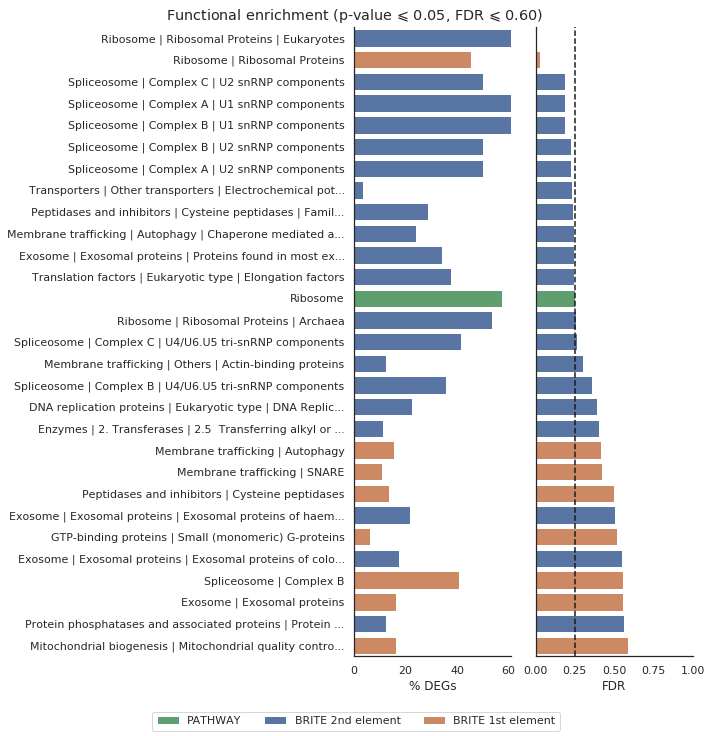

In [17]:
fig, axes = plt.subplots( 1, 2, figsize=(10, 10), sharey=True )
plt.suptitle('Functional enrichment (p-value $\leqslant$ 0.05, FDR $\leqslant$ 0.60)', y=1.01)

order = to_disp[ to_disp['variable'] == 'FDR' ].sort_values(by='value') # sort terms by FDR

sns.barplot( data=to_disp[ to_disp['variable'] == '% DEGs' # select the column
                         ].set_index('term').loc[order['term'].values, :].reset_index(),  # sort terms by FDR
             x='value', y='term', hue='type', ax=axes[0], orient='h', dodge=False )
sns.barplot( data=order,
             x='value', y='term', hue='type', ax=axes[1], orient='h', dodge=False )

x = axes[1]
x.axvline(0.25, color='k', linestyle='--')

axes[0].set( xlim=(0,61), ylabel='', xlabel='% DEGs' )
axes[1].set( xlim=(0,1), ylabel='', xlabel='FDR' )
axes[0].legend().remove()
axes[1].legend().remove()

# legend
h, l = axes[1].get_legend_handles_labels() # get legend elements
texts = sorted( [(i, h[i], text) for i, text in enumerate(l)],
                key=lambda x: x[2], reverse=True ) # sort elements according to the texts
h, l = [ elmt[1] for elmt in texts ], [ elmt[2] for elmt in texts ] # reorder elements
leg = fig.legend(h, l, loc="lower center", ncol=4)

sns.despine(bottom=False)
plt.tight_layout(rect=[0,.04,1,1]) # give space for legend at the bottom
plt.savefig('../figures/kegg_enrichment.png', dpi=300, bbox_inches='tight')
plt.show()